In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

# Работа с данными

In [23]:
X = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv")
y = y.values.ravel()

In [3]:
X

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0
...,...,...,...,...,...,...,...,...,...,...
105104,0.017608,62,0,0.184589,9928.125255,6,0,2,0,0.0
105105,0.980631,25,0,0.158753,2187.355843,3,0,0,0,0.0
105106,0.050256,73,1,0.849711,3961.841113,12,0,2,0,0.0
105107,0.447882,43,0,0.068033,3705.546719,4,0,0,1,0.0


Проверим пропущенные значения

In [4]:
X.isnull().sum()

credit_card_utilization           0
age                               0
overdue_30_59_days                0
debt_to_income                    0
monthly_income                20993
credits_loans                     0
overdue__more_than_90_days        0
mortgage_loans                    0
overdue_60_89_days                0
family_members                 2805
dtype: int64

In [24]:
X['family_members'] = X['family_members'].fillna(X['family_members'].dropna().median())
X['monthly_income'] = X['monthly_income'].fillna(X['monthly_income'].dropna().std())

In [7]:
X.isnull().sum()

credit_card_utilization       0
age                           0
overdue_30_59_days            0
debt_to_income                0
monthly_income                0
credits_loans                 0
overdue__more_than_90_days    0
mortgage_loans                0
overdue_60_89_days            0
family_members                0
dtype: int64

Посмотрим на гистограммы признаков

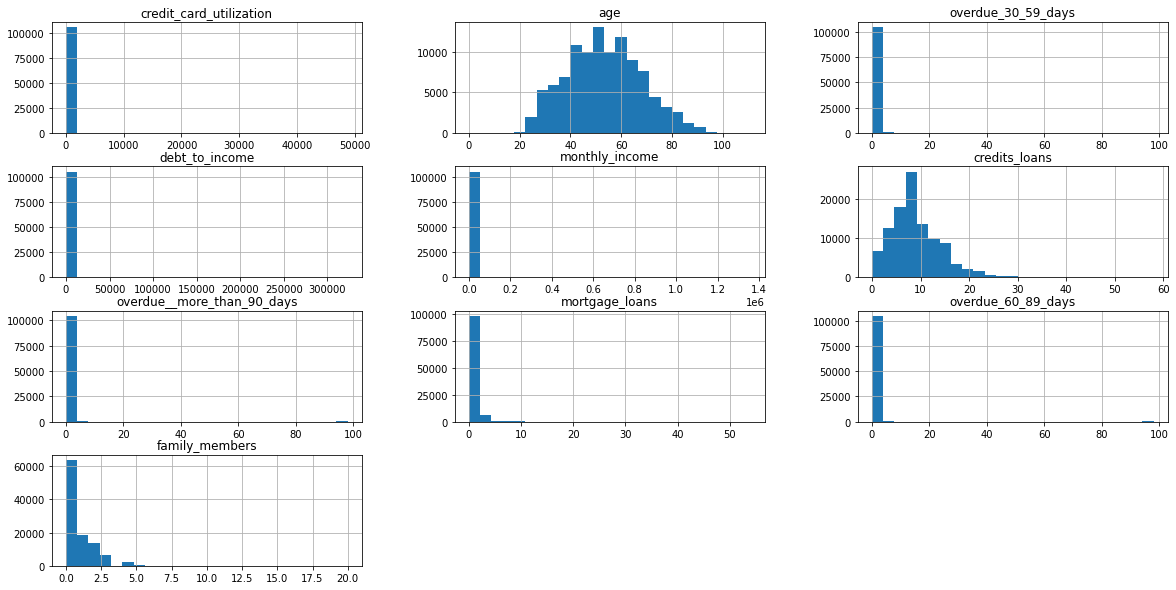

In [8]:
X.hist(figsize=(20,10), bins=25)
plt.show()

Есть выбросы, поэтому почистим их

In [25]:
X_fix = X

In [26]:
X_fix.loc[X_fix['debt_to_income'] >= 5, 'debt_to_income'] = 5
X_fix.loc[X_fix['credit_card_utilization'] >= 5, 'credit_card_utilization'] = 5
X_fix.loc[X_fix['overdue_30_59_days'] >= 1, 'overdue_30_59_days'] = 1
X_fix.loc[X_fix['overdue_60_89_days'] >= 1, 'overdue_60_89_days'] = 1
X_fix.loc[X_fix['overdue__more_than_90_days'] >= 1, 'overdue__more_than_90_days'] = 1
X_fix.loc[X_fix['monthly_income'] >= 30000, 'monthly_income'] = 30000
X_fix.loc[X_fix['credits_loans'] >= 25, 'credits_loans'] = 25
X_fix.loc[X_fix['family_members'] >= 4, 'family_members'] = 4
X_fix.loc[X_fix['mortgage_loans'] >= 4, 'mortgage_loans'] = 4

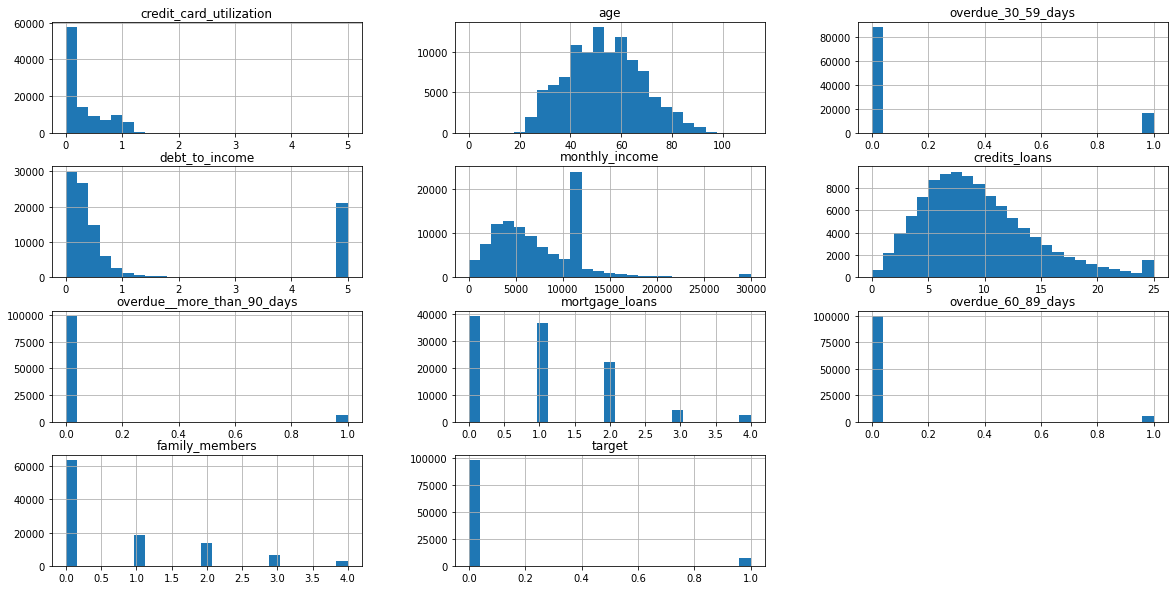

In [12]:
X_fix.hist(figsize=(20,10), bins=25)
plt.show()

Матрица корреляции

In [13]:
Xcorr_matrix = X_fix.corr()

<AxesSubplot:>

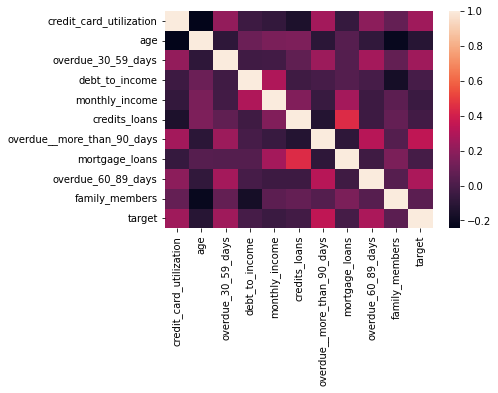

In [14]:
sns.heatmap(Xcorr_matrix)

Отмасштабируем данные и почистим тестовые данные

In [27]:
scaler = StandardScaler()

X_control = pd.read_csv('X_test.csv')
X_control = X_control.set_index(X_control.columns[0])
y_control = pd.read_csv('y_test_sample.csv')

X_control['family_members'] = X_control['family_members'].fillna(X_control['family_members'].dropna().median())
X_control['monthly_income'] = X_control['monthly_income'].fillna(X_control['monthly_income'].dropna().std())

In [28]:
X_control.loc[X_control['debt_to_income'] >= 1, 'debt_to_income'] = 1
X_control.loc[X_control['credit_card_utilization'] >= 1, 'credit_card_utilization'] = 1
X_control.loc[X_control['overdue_30_59_days'] >= 5, 'overdue_30_59_days'] = 5
X_control.loc[X_control['overdue_60_89_days'] >= 5, 'overdue_60_89_days'] = 5
X_control.loc[X_control['overdue__more_than_90_days'] >= 5, 'overdue__more_than_90_days'] = 5
X_control.loc[X_control['monthly_income'] >= 40000, 'monthly_income'] = 40000
X_control.loc[X_control['credits_loans'] >= 30, 'credits_loans'] = 30
X_control.loc[X_control['family_members'] >= 6, 'family_members'] = 6
X_control.loc[X_control['mortgage_loans'] >= 5, 'mortgage_loans'] = 5

In [29]:
X_control_scal = scaler.fit_transform(X_control)
X_scal = scaler.fit_transform(X_fix)

Разбиваем на тестовую и обучающую выборку

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scal, y, test_size=0.3)

# Модели

#### Логистическая модель

In [31]:
model = LogisticRegression()
params = {'C': np.logspace(-12, 1, 20)}
GridS_LR = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='roc_auc')
GridS_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-12, 4.83293024e-12, 2.33572147e-11, 1.12883789e-10,
       5.45559478e-10, 2.63665090e-09, 1.27427499e-08, 6.15848211e-08,
       2.97635144e-07, 1.43844989e-06, 6.95192796e-06, 3.35981829e-05,
       1.62377674e-04, 7.84759970e-04, 3.79269019e-03, 1.83298071e-02,
       8.85866790e-02, 4.28133240e-01, 2.06913808e+00, 1.00000000e+01])},
             scoring='roc_auc')

In [32]:
print('Best params: ', GridS_LR.best_params_)
print('Best score: ', GridS_LR.best_score_)

Best params:  {'C': 0.0007847599703514623}
Best score:  0.8553674969461851


In [33]:
LR = LogisticRegression(**GridS_LR.best_params_)
LR.fit(X_train, y_train)

LogisticRegression(C=0.0007847599703514623)

In [34]:
cv_auc = cross_val_score(LR, X_train, y_train, cv = 5, scoring ='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [0.85288024 0.84764926 0.85510384 0.85678345 0.8644207 ]


In [36]:
y_pred = LR.predict(X_test)

In [41]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, LR.predict_proba(X_test)[:,1]))

Accuracy score:  0.9347667522912504
Precision score:  0.5382003395585738
Recall score:  0.15080875356803045
ROC AUC score:  0.8433557650252017


In [647]:
result = LR.predict_proba(X_control_scal)[:,1]
y_control['target'] = result

In [648]:
y_control.to_csv('LogRegr.csv', index = False)

#### Метод k ближайших соседей

In [43]:
model = KNeighborsClassifier()
params = { 'n_neighbors': (1,10, 1) }
GridS_kNN = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='roc_auc')
GridS_kNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (1, 10, 1)}, scoring='roc_auc')

In [44]:
print('Best params: ', GridS_kNN.best_params_)
print('Best score: ', GridS_kNN.best_score_)

Best params:  {'n_neighbors': 10}
Best score:  0.7864788148192088


In [45]:
kNN = KNeighborsClassifier(**GridS_kNN.best_params_)

In [52]:
kNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [53]:
cv_auc = cross_val_score(kNN, X_test, y_test, cv = 5, scoring ='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [0.75889733 0.75729276 0.75352642 0.78767576 0.76996181]


In [54]:
y_pred = kNN.predict(X_test)

In [55]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, kNN.predict_proba(X_test)[:,1]))

Accuracy score:  0.9338787936447531
Precision score:  0.5150442477876106
Recall score:  0.1384395813510942
ROC AUC score:  0.7831525484901856


In [50]:
result = kNN.predict_proba(X_control_scal)[:,1]
y_control['target'] = result

In [51]:
y_control.to_csv('result_kNN.csv', index = False)

#### Decision Tree

In [83]:
model = DecisionTreeClassifier()
params = { 'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150] }
GridS_DTree = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='roc_auc')
GridS_DTree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]},
             scoring='roc_auc')

In [84]:
print('Best params: ', GridS_DTree.best_params_)
print('Best score: ', GridS_DTree.best_score_)

Best params:  {'max_depth': 6}
Best score:  0.8461370847200126


In [85]:
DTree = DecisionTreeClassifier(**GridS_DTree.best_params_)

In [86]:
DTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [87]:
cv_auc = cross_val_score(DTree, X_test, y_test, cv = 5, scoring ='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [0.81784663 0.80544317 0.81840036 0.84052756 0.83552639]


In [88]:
y_pred = DTree.predict(X_test)

In [89]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, DTree.predict_proba(X_test)[:,1]))

Accuracy score:  0.9357815621729617
Precision score:  0.5679012345679012
Recall score:  0.15318744053282587
ROC AUC score:  0.8319461498440724


In [90]:
result = DTree.predict_proba(X_control_scal)[:,1]
y_control['target'] = result

In [91]:
y_control.to_csv('result_DTree.csv', index = False)

#### Random forest

In [56]:
model = RandomForestClassifier()

In [57]:
param_grid = { 'n_estimators': [200, 700] }

In [58]:
GridS_RF = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring='roc_auc')
GridS_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [200, 700]}, scoring='roc_auc')

In [59]:
print('Best params: ', GridS_RF.best_params_)
print('Best score: ', GridS_RF.best_score_)

Best params:  {'n_estimators': 700}
Best score:  0.847952287376917


In [60]:
RandForest = RandomForestClassifier(n_estimators = 500)

In [63]:
RandForest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [70]:
cv_auc = cross_val_score(RandForest, X_test, y_test, cv = 5, scoring ='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [0.81847068 0.82300386 0.83596932 0.84890317 0.83293347]


In [64]:
y_pred = RandForest.predict(X_test)

In [65]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, RandForest.predict_proba(X_test)[:,1]))

Accuracy score:  0.9347033266736435
Precision score:  0.5317577548005908
Recall score:  0.17126546146527116
ROC AUC score:  0.8379367377084577


In [66]:
result = RandForest.predict_proba(X_control_scal)[:,1]

In [67]:
y_control['target'] = result
y_control.to_csv('result_RandForest.csv', index = False)

#### Градиентный бустинг 

In [71]:
params = { 'learning_rate': [0.03, 0.1] }

In [72]:
model = CatBoostClassifier()

In [74]:
GridS_CBC = GridSearchCV(estimator=model, param_grid = params, cv = 5, n_jobs=-1, scoring='roc_auc')
GridS_CBC.fit(X_test, y_test)

0:	learn: 0.6470859	total: 61.2ms	remaining: 1m 1s
1:	learn: 0.6070367	total: 68.8ms	remaining: 34.3s
2:	learn: 0.5741609	total: 76.4ms	remaining: 25.4s
3:	learn: 0.5438992	total: 84.4ms	remaining: 21s
4:	learn: 0.5162938	total: 92.1ms	remaining: 18.3s
5:	learn: 0.4897694	total: 100ms	remaining: 16.6s
6:	learn: 0.4650976	total: 109ms	remaining: 15.4s
7:	learn: 0.4420392	total: 117ms	remaining: 14.5s
8:	learn: 0.4212762	total: 125ms	remaining: 13.7s
9:	learn: 0.4024827	total: 133ms	remaining: 13.1s
10:	learn: 0.3855468	total: 141ms	remaining: 12.7s
11:	learn: 0.3681794	total: 150ms	remaining: 12.4s
12:	learn: 0.3536530	total: 159ms	remaining: 12.1s
13:	learn: 0.3396412	total: 171ms	remaining: 12s
14:	learn: 0.3282967	total: 178ms	remaining: 11.7s
15:	learn: 0.3173017	total: 189ms	remaining: 11.6s
16:	learn: 0.3086499	total: 195ms	remaining: 11.3s
17:	learn: 0.2991405	total: 203ms	remaining: 11.1s
18:	learn: 0.2909727	total: 209ms	remaining: 10.8s
19:	learn: 0.2824020	total: 216ms	remain

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000019D6D6DF040>,
             n_jobs=-1, param_grid={'learning_rate': [0.03, 0.1]},
             scoring='roc_auc')

In [75]:
print('Best params: ', GridS_CBC.best_params_)
print('Best score: ', GridS_CBC.best_score_)

Best params:  {'learning_rate': 0.03}
Best score:  0.8462926048710964


In [76]:
CBC = CatBoostClassifier(**GridS_CBC.best_params_)

In [77]:
CBC.fit(X_train, y_train)

0:	learn: 0.6464786	total: 17.5ms	remaining: 17.4s
1:	learn: 0.6056584	total: 28.7ms	remaining: 14.3s
2:	learn: 0.5739472	total: 39.4ms	remaining: 13.1s
3:	learn: 0.5428975	total: 52ms	remaining: 12.9s
4:	learn: 0.5145878	total: 65.1ms	remaining: 13s
5:	learn: 0.4861872	total: 76ms	remaining: 12.6s
6:	learn: 0.4616609	total: 87.6ms	remaining: 12.4s
7:	learn: 0.4392147	total: 101ms	remaining: 12.5s
8:	learn: 0.4184816	total: 110ms	remaining: 12.1s
9:	learn: 0.3974355	total: 122ms	remaining: 12s
10:	learn: 0.3785936	total: 135ms	remaining: 12.1s
11:	learn: 0.3622682	total: 147ms	remaining: 12.1s
12:	learn: 0.3464759	total: 158ms	remaining: 12s
13:	learn: 0.3343540	total: 169ms	remaining: 11.9s
14:	learn: 0.3233702	total: 184ms	remaining: 12.1s
15:	learn: 0.3121475	total: 202ms	remaining: 12.4s
16:	learn: 0.3014177	total: 217ms	remaining: 12.5s
17:	learn: 0.2922548	total: 229ms	remaining: 12.5s
18:	learn: 0.2833667	total: 240ms	remaining: 12.4s
19:	learn: 0.2752724	total: 250ms	remaining:

In [78]:
cv_auc = cross_val_score(CBC, X_test, y_test, cv = 5, scoring ='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

0:	learn: 0.6465450	total: 7.59ms	remaining: 7.58s
1:	learn: 0.6062029	total: 13.3ms	remaining: 6.62s
2:	learn: 0.5733107	total: 18.6ms	remaining: 6.18s
3:	learn: 0.5430397	total: 23.9ms	remaining: 5.96s
4:	learn: 0.5154215	total: 29.3ms	remaining: 5.84s
5:	learn: 0.4887321	total: 34.6ms	remaining: 5.74s
6:	learn: 0.4640621	total: 39.7ms	remaining: 5.63s
7:	learn: 0.4415791	total: 45.4ms	remaining: 5.63s
8:	learn: 0.4207902	total: 51.1ms	remaining: 5.63s
9:	learn: 0.4025380	total: 56.6ms	remaining: 5.61s
10:	learn: 0.3853154	total: 63ms	remaining: 5.67s
11:	learn: 0.3679019	total: 67.9ms	remaining: 5.59s
12:	learn: 0.3532708	total: 72.6ms	remaining: 5.51s
13:	learn: 0.3391101	total: 77.9ms	remaining: 5.49s
14:	learn: 0.3276828	total: 82.3ms	remaining: 5.41s
15:	learn: 0.3179654	total: 89.1ms	remaining: 5.48s
16:	learn: 0.3092390	total: 92.7ms	remaining: 5.36s
17:	learn: 0.2996080	total: 98.5ms	remaining: 5.37s
18:	learn: 0.2911028	total: 104ms	remaining: 5.35s
19:	learn: 0.2827824	tota

In [79]:
y_pred = CBC.predict(X_test)

In [80]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, CBC.predict_proba(X_test)[:,1]))

Accuracy score:  0.9355278597025338
Precision score:  0.552833078101072
Recall score:  0.17174119885823025
ROC AUC score:  0.8554550709183482


In [81]:
result = CBC.predict_proba(X_control_scal)[:,1]

In [82]:
y_control['target'] = result
y_control.to_csv('result_GradientBoost.csv', index = False)